In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', '..', 'notebook_format'))
from formats import load_style
load_style(plot_style = False)

In [2]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. a ipython magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,sklearn

Ethen 2017-10-10 17:39:01 

CPython 3.5.2
IPython 6.1.0

numpy 1.13.3
pandas 0.20.3
matplotlib 2.0.0
sklearn 0.19.0


# Text Machine Learning with scikit-learn

## Agenda

1. Model building in scikit-learn (quick refresher).
2. Representing text as numerical data.
3. Reading a text-based dataset into pandas and vectorizing.
4. Building and evaluating a model (naive-bayes).
5. Building and evaluating another model (logisitic regression).
6. Examining a model for further insight.
7. Tuning the vectorizer (commonly used parameters).

## Part 1: Model building in scikit-learn (refresher)

If you're already familiar with model-building in different packages, here's a quick refresher on how to train a simple classification model with scikit-learn.

In [3]:
# load the iris dataset as an example
from sklearn.datasets import load_iris
iris = load_iris()

In [4]:
# store the feature matrix (X) and response vector (y)
# by convention X is capitialized simply because it's a two-dimension matrix
X = iris.data
y = iris.target

**"Features"** are also known as predictors, inputs, or attributes. The **"response"** is also known as the target, label, or output.

In [5]:
# check the shapes of X and y
print(X.shape)
print(y.shape)

(150, 4)
(150,)


**"Observations"** are also known as samples, instances, or records.

In [6]:
# examine the first 5 rows of the feature matrix (including the feature names)
pd.DataFrame(X, columns = iris.feature_names).head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [7]:
# examine the response vector
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In order to **build a model**, the features must be **numeric**, and every observation must have the **same features in the same order**.

In [8]:
# import the class
from sklearn.neighbors import KNeighborsClassifier

# instantiate the model (with the default parameters)
knn = KNeighborsClassifier()

# fit the model with data (occurs in-place)
# learning the relationship between X and y
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In order to **make a prediction**, the new observation must have the **same features in the same order as the training observations**, both in number and meaning.

In [9]:
# predict the response for a new observation
knn.predict([[3, 5, 4, 2]])

array([1])

## Part 2: Representing text as numerical data

In [10]:
# example text for model training (SMS messages)
simple_train = ['call you tonight', 'Call me a cab', 'please call me... PLEASE!']

From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect **numerical feature vectors with a fixed size** rather than the **raw text documents with variable length**.

Thus, when working with text, we will use [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to "convert text into a matrix of token counts":

In [11]:
# import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [12]:
# learn the 'vocabulary' of the training data and transform 
# it into a 'document-term matrix'. Unlike models, for any 
# feature extraction or data-preprocessing toolkit, you use transform 
# instead of prediction, since it's taking some data and "transforming" it,
# fit_transform is just a shortcut for calling .fit and .transform separately
simple_train_dtm = vect.fit_transform(simple_train)
simple_train_dtm

<3x6 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [13]:
# examine the fitted vocabulary
vect.get_feature_names()

['cab', 'call', 'me', 'please', 'tonight', 'you']

Notice, with the default parameters:

- Single character like `a` will be removed.
- Punctuations have been removed.
- Words have been converted to lower cases.
- The vocabulary has no duplicated.

In [14]:
# convert sparse matrix to a dense matrix 
simple_train_dtm.toarray()

array([[0, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 1, 2, 0, 0]], dtype=int64)

In [15]:
# examine the vocabulary and document-term matrix together.
# 3 * 6 matrix, because there're three documents and six tokens that were learned
# each number represents the counts for each token in each document
pd.DataFrame(simple_train_dtm.toarray(), columns = vect.get_feature_names())

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> In this scheme, features and samples are defined as follows:

> - Each individual token occurrence frequency (normalized or not) is treated as a **feature**.
> - The vector of all the token frequencies for a given document is considered a multivariate **sample**.

> A **corpus of documents** can thus be represented by a matrix with **one row per document** and **one column per token** (e.g. word) occurring in the corpus.

> We call **vectorization** the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the **Bag of Words** or "Bag of n-grams" representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

### Side Note On Sparse Matrices

In [16]:
# check the type of the document-term matrix
print(type(simple_train_dtm))

# examine the sparse matrix contents
# represented coordinates, and the values at that coordinates
print(simple_train_dtm)

<class 'scipy.sparse.csr.csr_matrix'>
  (0, 4)	1
  (0, 5)	1
  (0, 1)	1
  (1, 0)	1
  (1, 2)	1
  (1, 1)	1
  (2, 3)	2
  (2, 2)	1
  (2, 1)	1


From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> As most documents will typically use a very small subset of the words used in the corpus, the resulting matrix will have **many feature values that are zeros** (typically more than 99% of them).

> For instance, a collection of 10,000 short text documents (such as emails) will use a vocabulary with a size in the order of 100,000 unique words in total while each document will use 100 to 1000 unique words individually.

> In order to be able to **store such a matrix in memory** but also to **speed up operations**, implementations will typically use a **sparse representation** such as the implementations available in the `scipy.sparse` package.

In [17]:
# example text for model testing
simple_test = ["please don't call me"]

In order to **make a prediction**, the new observation must have the **same features as the training observations**, both in number and meaning.

In [18]:
# transform testing data into a document-term matrix,
# using the existing vocabulary from the training data
simple_test_dtm = vect.transform(simple_test)
simple_test_dtm.toarray()

array([[0, 1, 1, 1, 0, 0]])

In [19]:
# examine the vocabulary and document-term matrix together
pd.DataFrame( simple_test_dtm.toarray(), columns = vect.get_feature_names() )

,cab,call,me,please,tonight,you
0,0,1,1,1,0,0


**Summary:**

- `vect.fit(train)` **learns the vocabulary** of the training data.
- `vect.transform(train)` uses the **fitted vocabulary** to build a document-term matrix from the training data. Or just `vect.fit_transform(train)` to combine the two steps into one.
- `vect.transform(test)` uses the **fitted vocabulary** to build a document-term matrix from the testing data. Note that it **ignores tokens** it hasn't seen before, this is reasonable due to the fact that the word does not exist in the training data, thus the model doesn't know anything about the relationship between the word and the output.

## Part 3: Reading a text-based dataset into pandas and vectorizing

This is a text data that has been labeled as spam and ham (non-spam), our goal is to see if we can correctly classify the labels using text messages.

In [20]:
# examine the data's shape and first 10 rows
sms = pd.read_table('sms.tsv', header = None, names = ['label', 'message'])
print('dimension:', sms.shape)
sms.head(10)

dimension: (5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [21]:
# alternative: read file into pandas from a URL
# url = 'https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv'
# sms = pd.read_table( url, header = None, names = ['label', 'message'] )

In [22]:
# examine the class distribution
sms['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [23]:
# convert label to a numerical variable
sms['label_num'] = sms['label'].map({'ham': 0, 'spam': 1})
sms.head(10)

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
6,ham,Even my brother is not like to speak with me. ...,0
7,ham,As per your request 'Melle Melle (Oru Minnamin...,0
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1


In [24]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
# COUNTVECTORIZER accepts one-dimension data
X = sms['message']
y = sms['label_num']
print(X.shape)
print(y.shape)

(5572,)
(5572,)


In [25]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

print(X_train.shape)
print(X_test.shape)

(4179,)
(1393,)


In [26]:
# instantiate the vectorizer
vect = CountVectorizer()

# learn training data vocabulary, then use it to create a document-term matrix
# equivalently: combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)

# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)

## Part 4: Building and evaluating a model

Algorithms are all treated as black box.

We will use [multinomial Naive Bayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html), Naive Bayes class algorithms are extremely fast and it's usually the go-to method for doing classification on text data.:

> The multinomial Naive Bayes classifier is suitable for classification with **discrete features** (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [27]:
# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# train the model using X_train_dtm (timing it with an IPython "magic command")
%time 
nb.fit(X_train_dtm, y_train)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [28]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

# calculate accuracy of class predictions
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

# print the confusion matrix
# metrics.confusion_matrix(y_test, y_pred_class)

# calculate predicted probabilities for X_test_dtm
# extract the probability that each observation belongs to class 1,
# though the downside of naive bayes is that the probabilities are poorly calibrated
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]

# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.988513998564


0.98664310005369615

## Part 5: Building and evaluating another model

We will compare multinomial Naive Bayes with [logistic regression](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression):

> Logistic regression, despite its name, is a **linear model for classification** rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

In [29]:
# import and instantiate a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

# train the model using X_train_dtm
# it accepts both sparse and dense arrays
%time 
logreg.fit(X_train_dtm, y_train)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 5.01 µs


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

# calculate accuracy
print(metrics.accuracy_score(y_test, y_pred_class))

# calculate predicted probabilities for X_test_dtm (well calibrated)
# it's a good model if you care about predicting the classified probability
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]

# calculate auc
metrics.roc_auc_score(y_test, y_pred_prob)

0.987796123475


0.99368176123143015

## Part 6: Examining a model for further insight

After building the model, it's a good practice to look at examples of where your model got it wrong, and think about what features you can add to "maybe" improve the performance.

In [31]:
# print message text for the false positives (ham incorrectly classified as spam)
print('false positives')
print(X_test[(y_pred_class == 1) & (y_test == 0)])
# equivalent way to performing the operation
# print(X_test[y_pred_class > y_test])


# print message text for the false negatives (spam incorrectly classified as ham)
print('\nfalse negatives')
print(X_test[y_pred_class < y_test])

# example false negative
X_test[3132]

false positives
2340    Cheers for the message Zogtorius. Ive been st...
Name: message, dtype: object

false negatives
1777                    Call FREEPHONE 0800 542 0578 now!
763     Urgent Ur £500 guaranteed award is still uncla...
3132    LookAtMe!: Thanks for your purchase of a video...
1045    We know someone who you know that fancies you....
684     Hi I'm sue. I am 20 years old and work as a la...
4073    Loans for any purpose even if you have Bad Cre...
1875    Would you like to see my XXX pics they are so ...
4298    thesmszone.com lets you send free anonymous an...
4394    RECPT 1/3. You have ordered a Ringtone. Your o...
4949    Hi this is Amy, we will be sending you a free ...
761     Romantic Paris. 2 nights, 2 flights from £79 B...
3991    (Bank of Granite issues Strong-Buy) EXPLOSIVE ...
2821    INTERFLORA - It's not too late to order Inter...
2863    Adult 18 Content Your video will be with you s...
2247    Hi ya babe x u 4goten bout me?' scammers getti...
4514    Mo

"LookAtMe!: Thanks for your purchase of a video clip from LookAtMe!, you've been charged 35p. Think you can do better? Why not send a video in a MMSto 32323."

After looking at these incorrectly classified messages, you might think does the message's length have something to do with it being a spam/ham. 

Next, we will examine the our trained Naive Bayes model to calculate the approximate **"spamminess" of each token** to see which word appears more often in spam messages.

In [32]:
# Naive Bayes counts the number of times each token appears in each class, where
# rows represent classes, columns represent tokens
# and the trailing _ is just the convention that's used to denote attributes that
# are learned during the model fitting process
print(nb.feature_count_)

# extract the number of times each token appears across all HAM and SPAM messages
ham_token_count = nb.feature_count_[0, :]
spam_token_count = nb.feature_count_[1, :]

[[  0.   0.   0. ...,   1.   1.   1.]
 [  5.  23.   2. ...,   0.   0.   0.]]


In [33]:
# store the vocabulary of X_train
X_train_tokens = vect.get_feature_names()
print(len(X_train_tokens))

# examine the first or last 50 tokens if you wish
# print(X_train_tokens[0:50])
# print(X_train_tokens[-50:])

# create a DataFrame of tokens with their separate ham and spam counts
tokens = pd.DataFrame({
    'token': X_train_tokens, 
    'ham': ham_token_count, 
    'spam': spam_token_count
}).set_index('token')
tokens.head()

7456


,ham,spam
token,,
00,0.0,5.0
000,0.0,23.0
008704050406,0.0,2.0
0121,0.0,1.0
01223585236,0.0,1.0


In [34]:
# examine 5 random DataFrame rows
tokens.sample(5, random_state = 6)

,ham,spam
token,,
very,64.0,2.0
nasty,1.0,1.0
villa,0.0,1.0
beloved,1.0,0.0
textoperator,0.0,2.0


In [35]:
# Naive Bayes counts the number of observations in each class
nb.class_count_

array([ 3617.,   562.])

Before we can calculate the relative "spamminess" of each token, we need to avoid **dividing by zero** and account for the **class imbalance**.

In [36]:
# add 1 to ham and spam counts to avoid dividing by 0
# convert the ham and spam counts into ratio frequencies
tokens['ham'] = (tokens['ham'] + 1) / nb.class_count_[0]
tokens['spam'] = (tokens['spam'] + 1) / nb.class_count_[1]

# calculate the conceptual ratio of spam-to-ham for each token
tokens['spam_ratio'] = tokens['spam'] / tokens['ham']
tokens.sample(5, random_state = 6)

,ham,spam,spam_ratio
token,,,
very,0.017971,0.005338,0.297044
nasty,0.000553,0.003559,6.435943
villa,0.000276,0.003559,12.871886
beloved,0.000553,0.001779,3.217972
textoperator,0.000276,0.005338,19.307829


In [37]:
# examine the DataFrame sorted by spam_ratio
# only interpret them as relative ratio instead of actual ratio 
# since we added the one to prevent zero division
tokens.sort_values('spam_ratio', ascending = False).head()

,ham,spam,spam_ratio
token,,,
claim,0.000276,0.158363,572.798932
prize,0.000276,0.135231,489.131673
150p,0.000276,0.087189,315.361210
tone,0.000276,0.085409,308.925267
guaranteed,0.000276,0.076512,276.745552


e.g. From the looks of it, the word claim appears a lot more often in spam messages than ham ones.

In [38]:
# look up the spam_ratio for a given token
tokens.loc['dating', 'spam_ratio']

83.667259786476862

## Part 7: Tuning the vectorizer

Thus far, we have been using the default parameters of [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html):

In [39]:
# show default parameters for CountVectorizer
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

However, the vectorizer is worth tuning, just like a model is worth tuning! Here are a few parameters that you might want to tune:

- **stop_words:** string {'english'}, list, or None (default)
    - If 'english', a built-in stop word list for English is used.
    - If a list, that list is assumed to contain stop words, all of which will be removed from the resulting tokens.
    - If None, no stop words will be used.
    
Removing common and uncommon words is extremely useful in text analytics. The rationale behind it is that common words such as 'the', 'a', or 'and' appear so commonly in the English language that they tell us almost nothing about how similar or dissimilar two documents might be, or in a sense, they carry less semantic weight. On the other hand, there may be words that only appear one of twice in the entire corpus and we simply don't have enough data about these words to learn a meaningful output.

In [40]:
# remove English stop words, these are usually commonly appeared words that
# probably don't provide a lot of usual messages. 
vect = CountVectorizer(stop_words = 'english')

- **ngram_range:** tuple (min_n, max_n), default=(1, 1)
    - The lower and upper boundary of the range of n-values for different n-grams to be extracted.
    - All values of n such that min_n <= n <= max_n will be used.

In [41]:
# include 1-grams and 2-grams
# it might be the case that word pairs has relationships with the output,
# e.g. with 2-grams "not happy" won't be split into "not" and "happy" and it might be predictive
# however, it still might introduce more noise than signals
vect = CountVectorizer(ngram_range = (1, 2))

- **max_df:** float in range [0.0, 1.0] or int, default=1.0
    - When building the vocabulary, ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words).
    - If float, the parameter represents a proportion of documents.
    - If integer, the parameter represents an absolute count.

In [42]:
# ignore terms if that appear too common, here when it
# appears in more than 50% of the documents
vect = CountVectorizer(max_df = 0.5)

- **min_df:** float in range [0.0, 1.0] or int, default=1
    - When building the vocabulary, ignore terms that have a document frequency strictly lower than the given threshold. (This value is also called "cut-off" in the literature.)
    - If float, the parameter represents a proportion of documents.
    - If integer, the parameter represents an absolute count.

In [43]:
# only keep terms that appear in at least 2 documents
vect = CountVectorizer(min_df = 2)

**Guidelines for tuning CountVectorizer:**

- Use your knowledge of the **problem** and the **text**, and your understanding of the **tuning parameters**, to help you decide what parameters to tune and how to tune them.
- **Experiment**, and let the data tell you the best approach!

In the cell below, we're simply putting the basic workflow of text classificatio's script into one cell for future reference's convenience.

In [44]:
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# using the example spam dataset
# read it in, extract the input and output columns
sms = pd.read_table('sms.tsv', header = None, names = ['label', 'message'])
sms['label_num'] = sms['label'].map({'ham': 0, 'spam': 1})
X = sms['message']
y = sms['label_num']

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

# convert both sets' text column to document-term matrix
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm  = vect.transform(X_test)

# train the mutinomial naive bayes model, 
# predict on the test set and output the accuracy score
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)
accuracy = metrics.accuracy_score(y_test, y_pred_class)
print('accuracy:', accuracy)

# train the logistic regression model, 
# predict on the test set and output the auc score
logreg = LogisticRegression()
logreg.fit(X_train_dtm, y_train)
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
auc = metrics.roc_auc_score(y_test, y_pred_prob)
print('auc', auc)

accuracy: 0.988513998564
auc 0.993681761231


In [45]:
def sparsity_ratio(X):
    """
    The rule of thumb is if the sparsity ratio is greater than 90% 
    then you can probably benefit from sparse formats, that are the 
    default representation of document-term matrix for scikit learn
    
    Parameters
    ----------
    X : scipy sparse matrix
        document-term matrix
        
    Returns
    -------
    sparsity : float
        the ratio of elements in the matrix that are zeros
    """
    sparsity = 1 - X.nnz / np.prod(X.shape)
    return sparsity


print('input sparsity ratio: ', sparsity_ratio(X_train_dtm))

input sparsity ratio:  0.998228130998


In [46]:
# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

def visualize_coefficients(coefficients, feature_names, n_top_features = 10):
    # obtain the top `n_top_features` coefficients of logsitic regresion
    # here top refers to the largest positive and negative coefficients
    
    # convert the coefficient to a 1d-array and obtain the 
    # positive and negative coefs with larger absolute values
    # and stack them together into one array
    coefs = coefficients.ravel()
    sorted_coefs = np.argsort(coefs)
    positive_coefs = sorted_coefs[-n_top_features:]
    negative_coefs = sorted_coefs[:n_top_features]
    top_coefs = np.hstack([negative_coefs, positive_coefs])

    fig = plt.figure(figsize = (15, 5))
    colors = ['#A60628' if c < 0 else '#348ABD' for c in coefs[top_coefs]]
    x_ticks = np.arange(2 * n_top_features)
    plt.bar(x_ticks, coefs[top_coefs], color = colors)
    feature_names = np.array(feature_names)
    plt.xticks(0.5 + x_ticks, feature_names[top_coefs], rotation = 90)
    plt.title('top {} positive/negative coefficient'.format(n_top_features))
    return fig

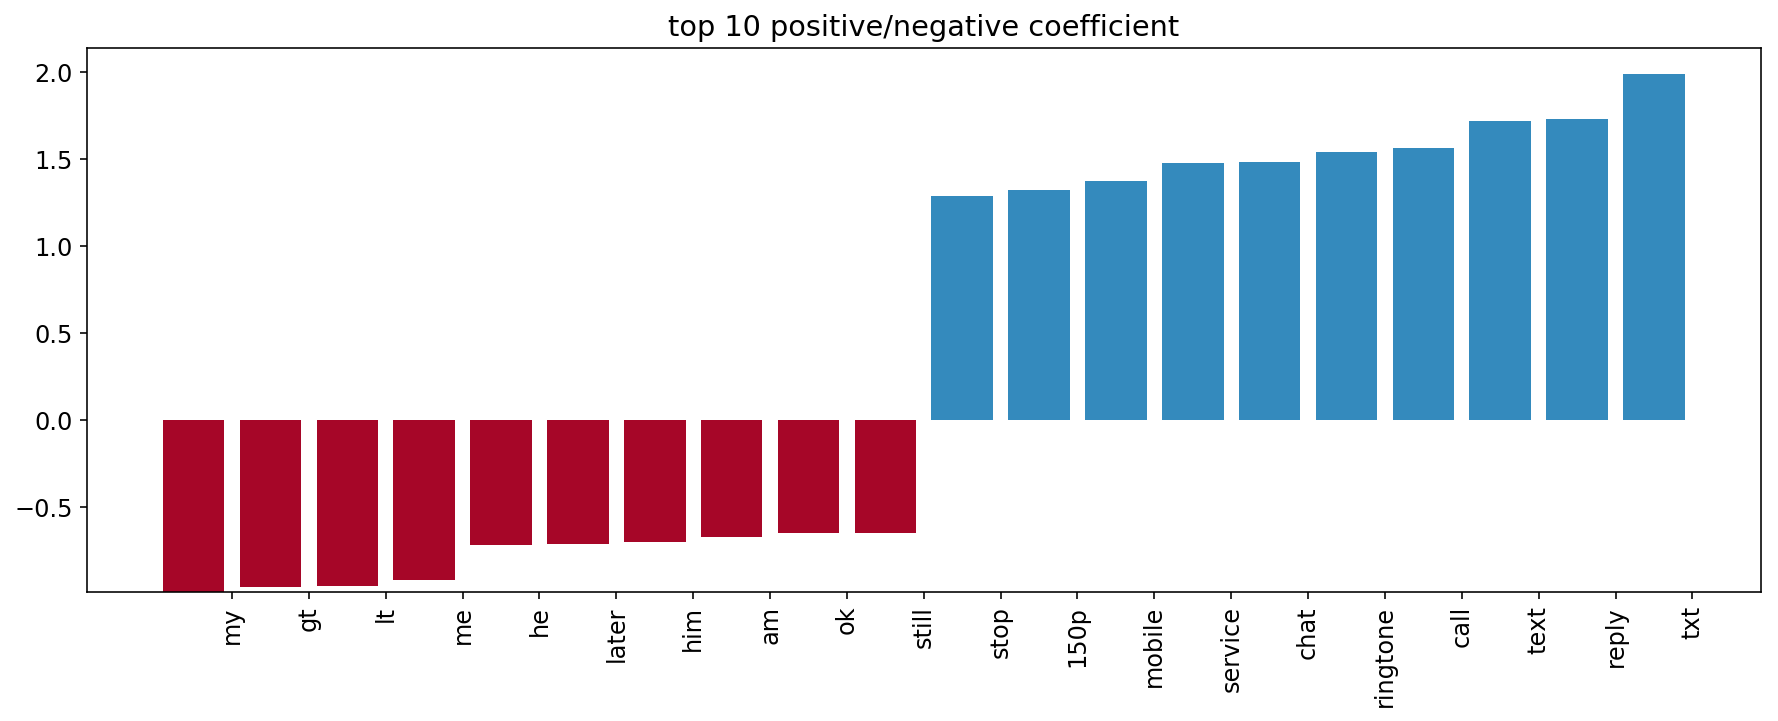

In [47]:
feature_names = vect.get_feature_names()

coef_plot = visualize_coefficients( 
    coefficients = logreg.coef_,
    feature_names = feature_names, 
    n_top_features = 10
)

# Reference

- [Youtube: PyCon 2016 Machine Learning with Text in scikit-learn](https://www.youtube.com/watch?v=znfy3T9OiAQ)
- [Github: PyCon 2016 Machine Learning with Text in scikit-learn](https://github.com/justmarkham/pycon-2016-tutorial)